In [1]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import BertTokenizerFast
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)

In [2]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification)

from pytorch_transformers import AdamW, WarmupLinearSchedule                                

In [3]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizerFast)
}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [4]:
def get_labels_from_label_dict(lbl_dict_path):
        line_id = 0
        labels = []
        for line in open(lbl_dict_path, encoding='utf8'):
            fds = line.strip().split(' ')
            assert len(fds) == 2, 'incorrect format {}'.format(line)
            lbl = fds[0]
            fid = int(fds[1])
            assert fid == line_id, 'id not correct {} -- {}'.format(fid, line_id)
            labels.append(lbl)
            line_id += 1
        return labels

In [5]:
def read_fasttext(infile):
        data = []
        # HACK for windows the first line causes utf problem...
        fFirstline = True
        for line in open(infile, 'r', encoding='utf-8-sig'):
            # __label__Step in st george wharf tower ) have modern and luxurious installations .
            fields = line.strip().split()
            words, label = [], ''
            for fd in fields:
                if fd.startswith('__label__'):
                    label = fd
                else:
                    words.append(fd)
            if label != '' and len(words) > 0:
                data.append((label, ' '.join(words)))

        return data

In [6]:
args = {
'data_dir':'C:\\Users\\ryserrao\\Microsoft_work\\AIPLATFORM_SHAP\\PPT_Text_to_Icon_Data\\Turing_Text2Icon_Code_and_Model\\outputs',
'model_name_or_path':'ft_set12_256x2_pcln2sc_nowiki.py_e10_wu02_bs8_ts08_sc12_lr7e-5',
'data_path':'test_mturk.txt',
'task_name':'text2content',
'do_lower_case':True,
'lbl_dict_path' : 'train.txt.lbl.dict.txt',
'max_seq_len':32
}
labels = get_labels_from_label_dict(os.path.join(args['data_dir'], args['lbl_dict_path']))
num_labels = len(labels)

In [28]:
label2id = {}
for i,label in enumerate(labels):
    label2id[label]=i

In [14]:
data = pd.DataFrame(read_fasttext(os.path.join(args['data_dir'], args['data_path'])), columns=['Label','Sentence'])

In [15]:
data.head()

,Label,Sentence
0,__label__Acorn,an acorn PUNC
1,__label__Add,there is alway an addition to the party PUNC
2,__label__Advertising,we specialize in outdoor billboard advertising PUNC
3,__label__Africa,the continent of africa PUNC
4,__label__Airplane,PUNC it PUNC s a symbol of airplane mode icon PUNC while travelling on a plane PUNC you have to put your mobile on this mode PUNC so PUNC that you wo n't get your network in the plane PUNC PUNC


In [11]:
config = config_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), num_labels=num_labels, finetuning_task=args['task_name'])

In [12]:
tokenizer = tokenizer_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), do_lower_case=args['do_lower_case'])

In [13]:
model = model_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']),config=config).cuda()

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "text2content",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "num_labels": 865,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler": "cls",
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [16]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

In [17]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

In [18]:
shap_values_multiclass = explainer(data['Sentence'][:1000])

Partition explainer: 695it [00:30, 23.13it/s]                         


In [22]:
def text_plot(class_index,start_idx,end_idx):
    shap_values = copy.copy(shap_values_multiclass[:])
    if len(shap_values.base_values.shape) == 1:
        shap_values.values = shap_values.values[:,class_index]
        shap_values.hierarchical_values = shap_values.hierarchical_values[:,class_index]
        shap_values.base_values = shap_values.base_values[class_index]
    else:
        for i in range(start_idx,end_idx):
            shap_values.values[i] = shap_values.values[i][:,class_index]
            shap_values.hierarchical_values[i] = shap_values.hierarchical_values[i][:,class_index]
        shap_values.base_values = shap_values.base_values[:,class_index]
    shap.plots.text(shap_values[start_idx:end_idx])

In [23]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

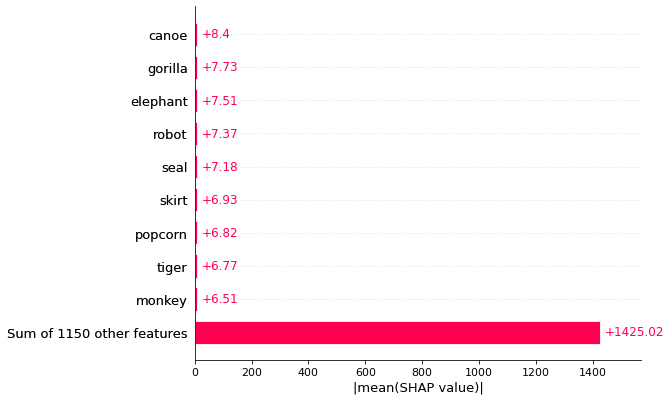

In [24]:
label='__label__Fire'
custom_masked_bar_plot(labels_to_idx[label],'neg','mean')

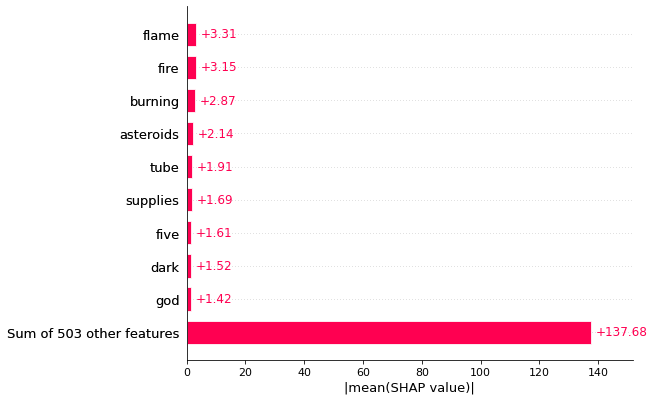

In [29]:
label='__label__Fire'
custom_masked_bar_plot(label2id[label],'pos','mean')

In [25]:
label='__label__Firefighter'
text_plot(label2id[label],231,232)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

#### Blocklist sentences

In [38]:
import pickle
pkl_path=r"C:\Users\ryserrao\Microsoft_work\AIPLATFORM_SHAP\PPT_Text_to_Icon_Data\blocklists\violent_words.pkl"
with open(pkl_path, 'rb') as f:
    violent_words = pickle.load(f)

In [56]:
violent_words_set=set()
for k,v in violent_words.items():
    violent_words_set.update(violent_words[k])

In [96]:
violent_words.keys()

dict_keys(['bomb', 'abuse', 'kill', 'beat', 'rape', 'shoot', 'suicide', 'dead', 'arms', 'viol'])

In [98]:
violent_words['kill']

{'babykilling',
 'babykillings',
 'catkiller',
 'christkiller',
 'christkillers',
 'ikilluever',
 'kill',
 'killary',
 'killed',
 'killer',
 'killerish',
 'killers',
 'killery',
 'killian',
 'killin',
 'killing',
 'killings',
 'killmonger',
 'killn',
 'kills',
 'killuminati',
 'killyoselph',
 'kkill',
 'ladykiller',
 'ladykillers',
 'painkiller',
 'painkillers',
 'petkiller',
 'skill',
 'skilled',
 'skills',
 'skillz',
 'sonofthekiller',
 'wifekiller'}

In [68]:
token_set=set()
def tokenize_sentence(s):
    token_set.update(s.split(' '))

#### Blocklist words for violence

In [85]:
violent_words_set

{'abomb',
 'abuse',
 'abused',
 'abuser',
 'abusering',
 'abuserings',
 'abusers',
 'abuses',
 'anarchybomb',
 'antabuse',
 'arms',
 'armscor',
 'armsel',
 'armsf',
 'armstrong',
 'asianrape',
 'auntyrape',
 'auntyraped',
 'auntysraped',
 'babykilling',
 'babykillings',
 'babyrape',
 'bbombs',
 'beat',
 'beata',
 'beated',
 'beaten',
 'beater',
 'beaters',
 'beatiful',
 'beatin',
 'beating',
 'beatings',
 'beatmymeat',
 'beatoff',
 'beats',
 'bhabirape',
 'bigrape',
 'bomb',
 'bombanarchy',
 'bombathome',
 'bombay',
 'bombbuilding',
 'bombcookbook',
 'bombed',
 'bomber',
 'bombers',
 'bombfactory',
 'bombido',
 'bombing',
 'bombings',
 'bombmakehow',
 'bombmaking',
 'bombrecipe',
 'bombs',
 'bombshell',
 'boyraped',
 'boysraped',
 'britarms',
 'broomrape',
 'broomrapes',
 'brotherraped',
 'brutalrape',
 'buildabomb',
 'buildbomb',
 'buildingbomb',
 'bullshooter',
 'carbomb',
 'catkiller',
 'ce_conf_viol',
 'celebrityrape',
 'childrape',
 'christkiller',
 'christkillers',
 'crapella',
 

In [69]:
_=data['Sentence'].apply(tokenize_sentence)

In [71]:
violent_words_intersection=list(token_set & violent_words_set)

In [72]:
violent_words_intersection

['kill', 'shooting', 'beats', 'beat', 'arms']

In [86]:
blocklist_sentences=[]
def print_blocklist_sentences(s):
    s_token_set=set(s.split(' '))
    if len(set(violent_words_intersection) & s_token_set)>0:
        print(s)
        blocklist_sentences.append(s)

In [87]:
_=data['Sentence'].apply(print_blocklist_sentences)

the outline of a man with his arms out PUNC
PUNC a hummingbird PUNC s heart rate can reach as high as 1,260 beats per minute PUNC PUNC
do not kill the bugs PUNC
shooting for the stars PUNC
a whale shooting water out of it PUNC s blowhole PUNC
an instrument that musician use to make certain type of beat for music PUNC


In [88]:
data.loc[data['Sentence'].isin(blocklist_sentences)]

,Label,Sentence
139,__label__ConfusedPerson,the outline of a man with his arms out PUNC
303,__label__HummingBird,"PUNC a hummingbird PUNC s heart rate can reach as high as 1,260 beats per minute PUNC PUNC"
324,__label__Ladybug,do not kill the bugs PUNC
574,__label__Stars,shooting for the stars PUNC
675,__label__Whale,a whale shooting water out of it PUNC s blowhole PUNC
689,__label__Xylophone,an instrument that musician use to make certain type of beat for music PUNC


#### Cumulative shap

In [79]:
def get_cumulative_shap_values(word_set,shap_values):
    token_list = shap_values_multiclass.abs.mean(0).feature_names.tolist()
    shap_values_multiclass_abs_mean = shap_values_multiclass.abs.mean(0)
    shap_values = []
    for word in word_set:
        shap_values_word = shap_values_multiclass_abs_mean.values[token_list.index(word)]
        shap_values.append(shap_values_word)
    
    return np.array(shap_values).mean(0)

In [82]:
get_cumulative_shap_values(violent_words_intersection,shap_values_multiclass)[labels_to_idx['__label__Xylophone']]

0.9207352576293795